# **Dropout Rate Analysis**

Expected Output: Focused interventions on the high dropout rates


**Importing Libraries**

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

In [ ]:
data = pd.read_csv("schooldropout.csv")

print(data.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

**Data Processing**

In [ ]:
data.isnull().sum()/len(data)*100

Marital status                                    0.0
Application mode                                  0.0
Application order                                 0.0
Course                                            0.0
Daytime/evening attendance                        0.0
Previous qualification                            0.0
Nacionality                                       0.0
Mother's qualification                            0.0
Father's qualification                            0.0
Mother's occupation                               0.0
Father's occupation                               0.0
Displaced                                         0.0
Educational special needs                         0.0
Debtor                                            0.0
Tuition fees up to date                           0.0
Gender                                            0.0
Scholarship holder                                0.0
Age at enrollment                                 0.0
International               

In [ ]:
print(data["Target"].unique())

['Dropout' 'Graduate' 'Enrolled']


In [ ]:
data['Target'] = data['Target'].map({
    'Dropout':0,
    'Enrolled':1,
    'Graduate':2
})

print(data["Target"].unique())

[0 2 1]


In [ ]:
correlations = data.corr()['Target']
print(correlations)

Marital status                                   -0.089804
Application mode                                 -0.212025
Application order                                 0.089791
Course                                            0.007841
Daytime/evening attendance                        0.075107
Previous qualification                           -0.091365
Nacionality                                      -0.004740
Mother's qualification                           -0.038346
Father's qualification                            0.000329
Mother's occupation                               0.048424
Father's occupation                               0.051702
Displaced                                         0.113986
Educational special needs                        -0.007353
Debtor                                           -0.240999
Tuition fees up to date                           0.409827
Gender                                           -0.229270
Scholarship holder                                0.2975

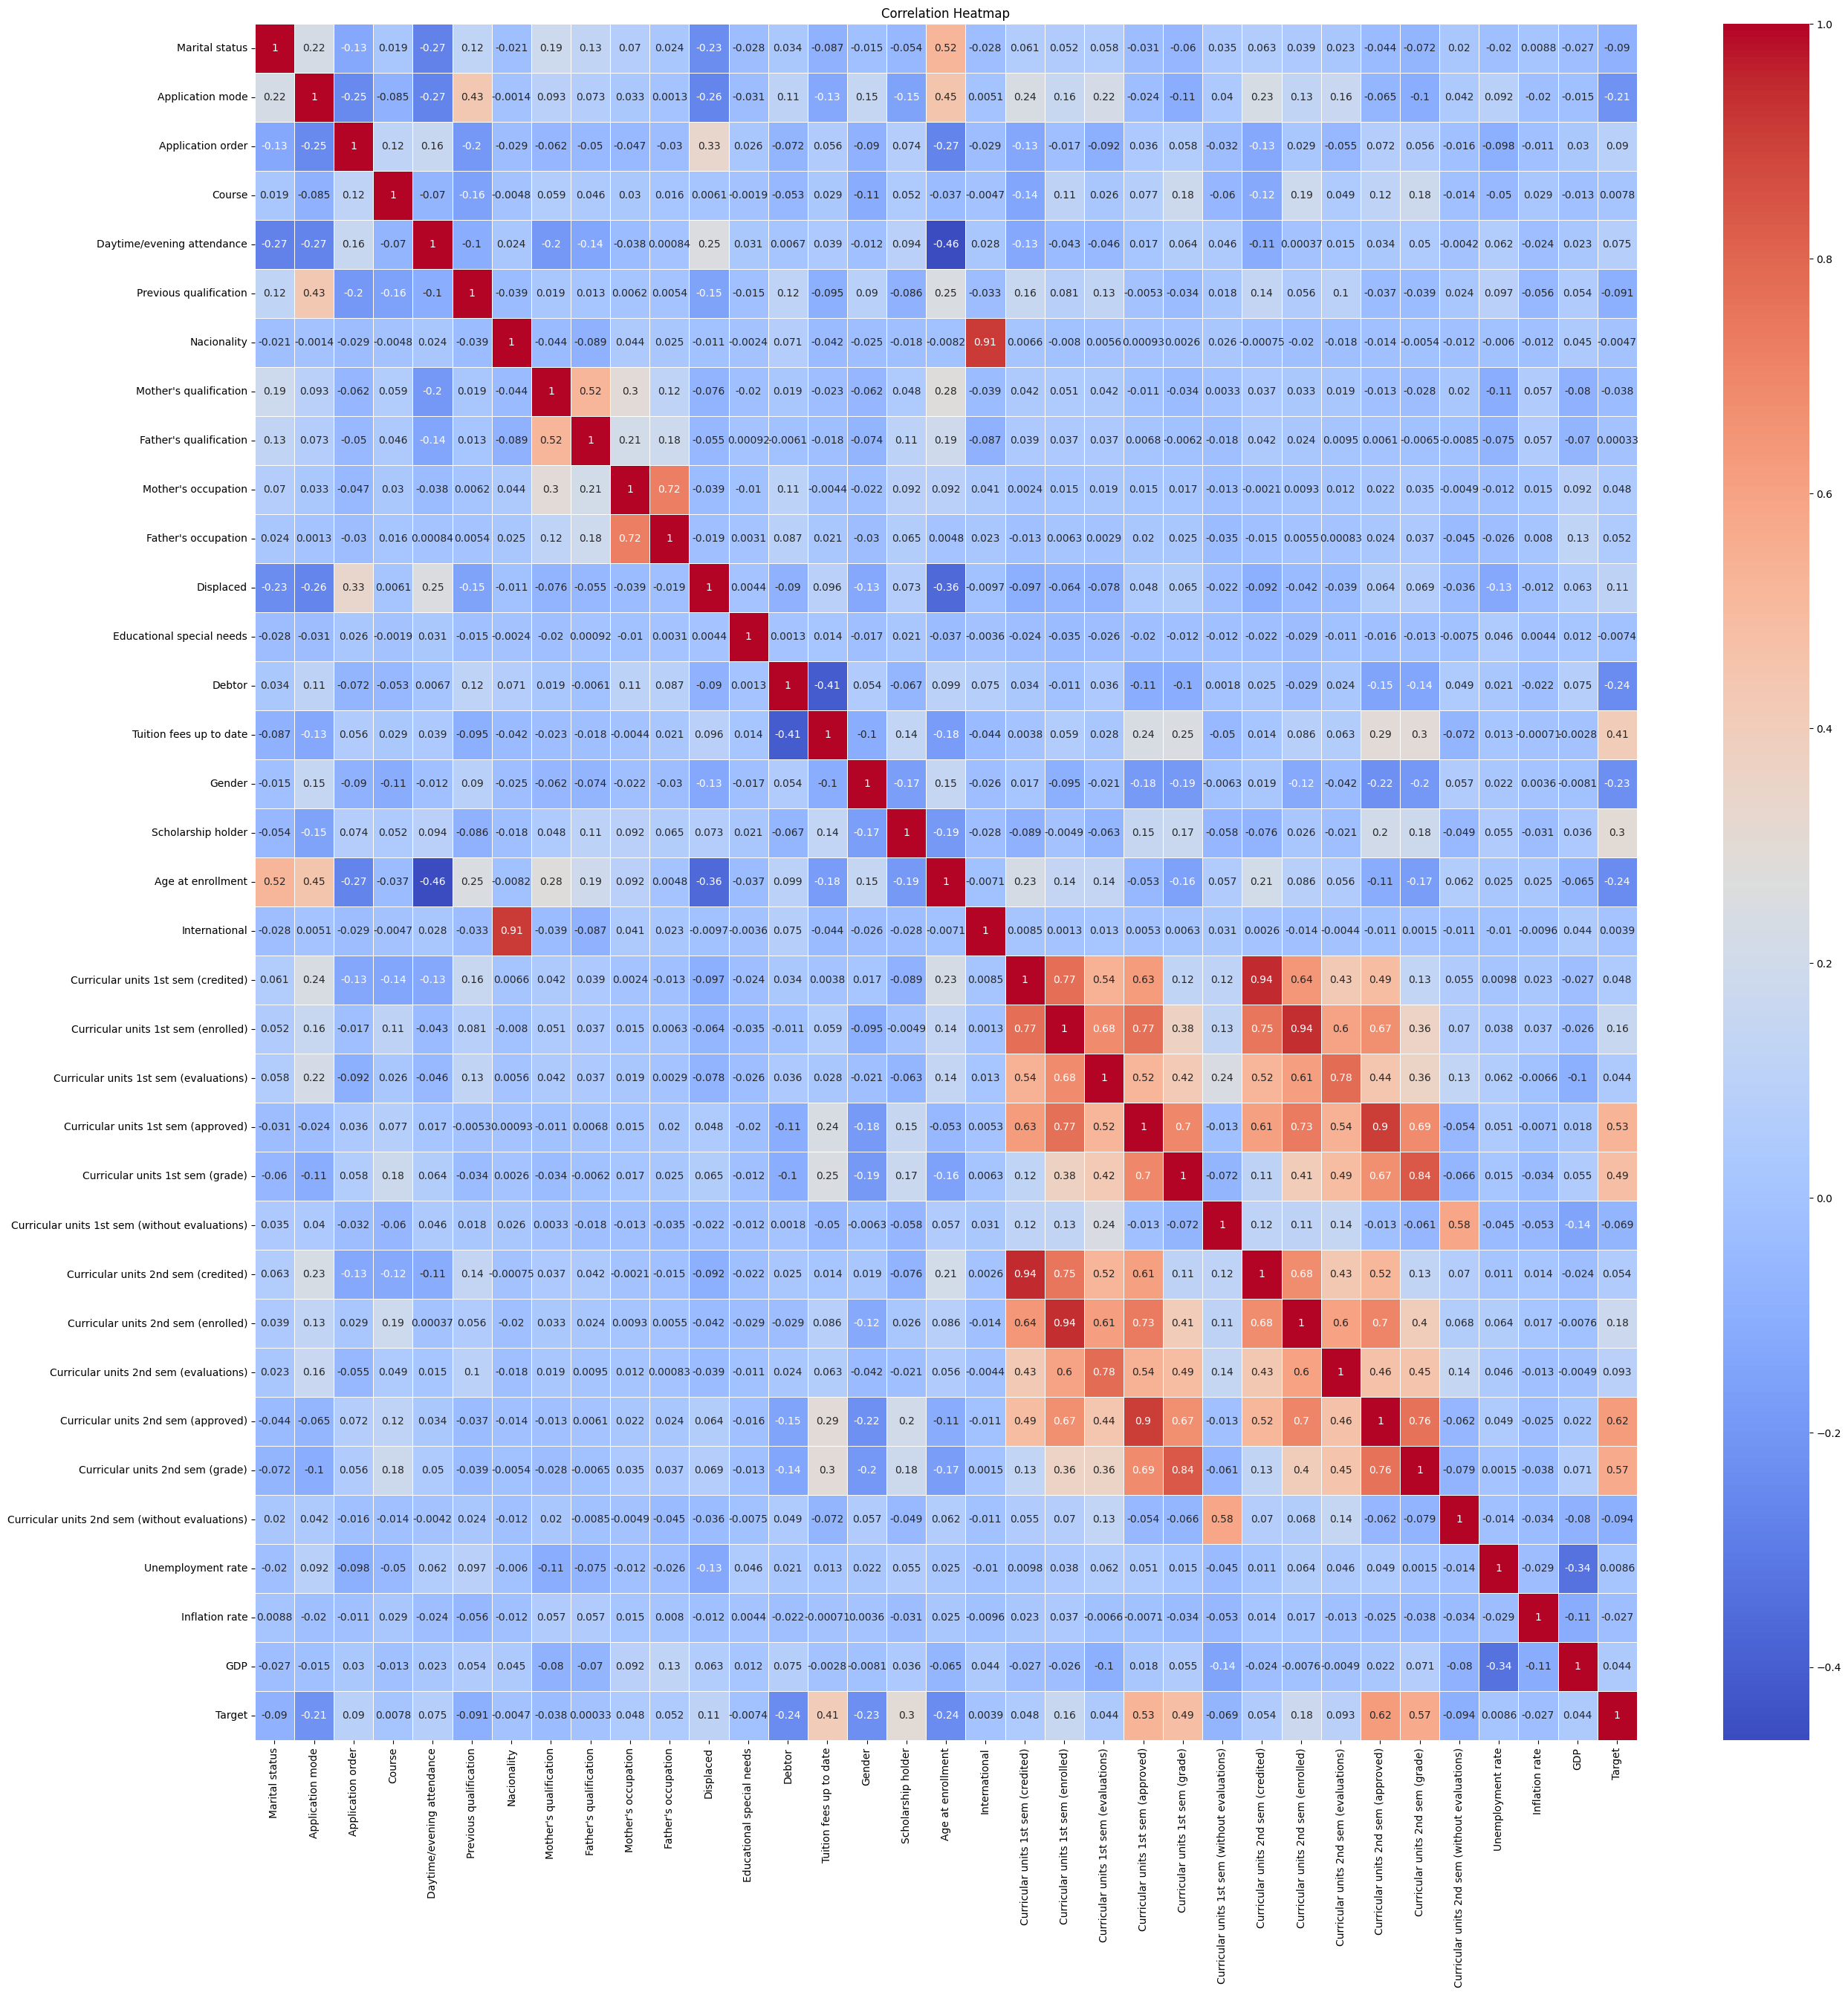

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(data.corr() , annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Identifying columns for removal:**

To identify columns for removal due to low correlation with the target variable ('Target'), we need to establish a correlation threshold and eliminate columns with correlations falling below this threshold. Here, I'm excluding columns with an **absolute** correlation coefficient less than 0.01 (adjustable based on requirements).
These columns have low absolute correlation values and may not provide significant predictive power for target variable 'Target.'

In [ ]:
threshold = 0.01

columns_to_drop = correlations[abs(correlations) <= threshold].index

new_data = data.drop(columns=columns_to_drop)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 29 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Daytime/evening attendance                      4424 non-null   int64  
 4   Previous qualification                          4424 non-null   int64  
 5   Mother's qualification                          4424 non-null   int64  
 6   Mother's occupation                             4424 non-null   int64  
 7   Father's occupation                             4424 non-null   int64  
 8   Displaced                                       4424 non-null   int64  
 9   Debtor                                   

**Exploratory Data Analysis (EDA)**

In [ ]:
new_data['Target'].value_counts()

2    2209
0    1421
1     794
Name: Target, dtype: int64

In [ ]:
x = new_data['Target'].value_counts().index
y = new_data['Target'].value_counts().values

df = pd.DataFrame({
    'Target': x,
    'Count_T' : y
})

fig = px.pie(df,
             names ='Target',
             values ='Count_T',
            title='Number of graduates, dropouts & enrolled')

fig.update_traces(labels=['Graduate','Dropout','Enrolled'],textinfo='value+label')
fig.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



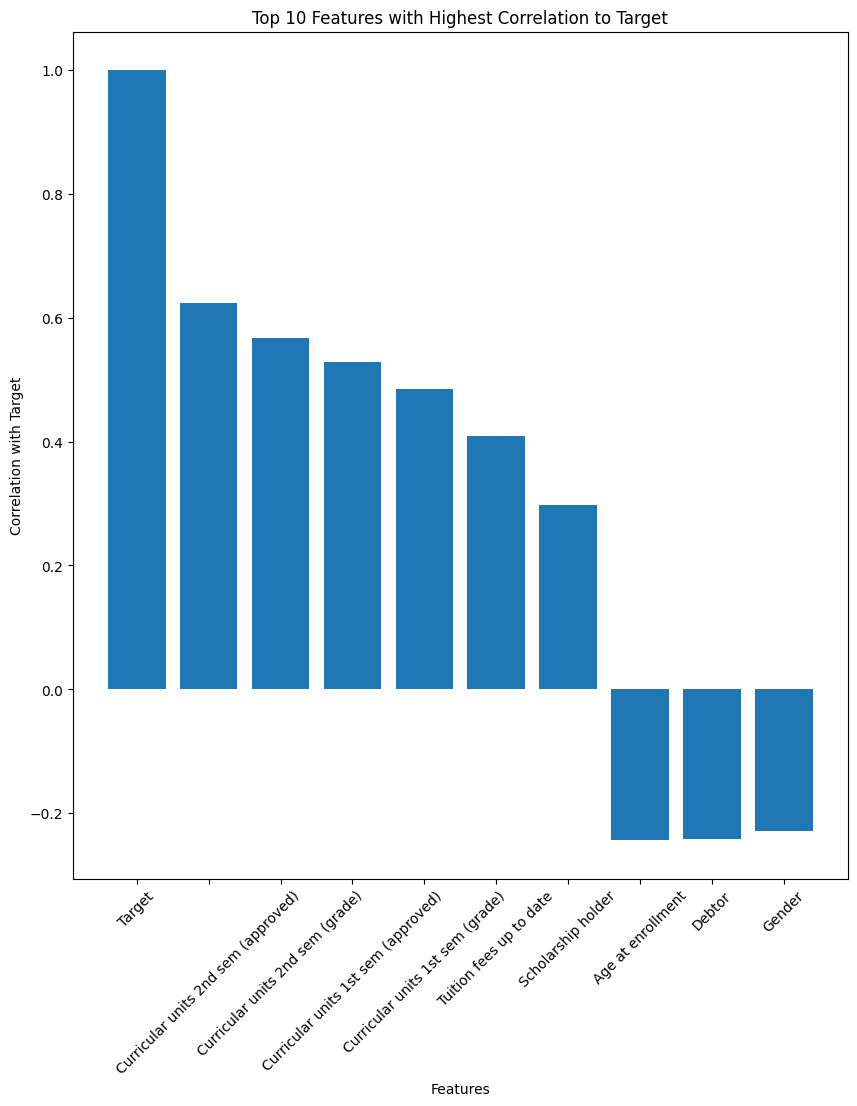

In [ ]:
correlations = new_data.corr()['Target']
top_10_features = correlations.abs().nlargest(10).index
top_10_corr_values = correlations[top_10_features]

plt.figure(figsize=(10, 11))
plt.bar(top_10_features, top_10_corr_values)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Top 10 Features with Highest Correlation to Target')
plt.xticks(rotation=45)
plt.show()

In [ ]:
px.histogram(new_data['Age at enrollment'], x='Age at enrollment',color_discrete_sequence=['lightpink'])

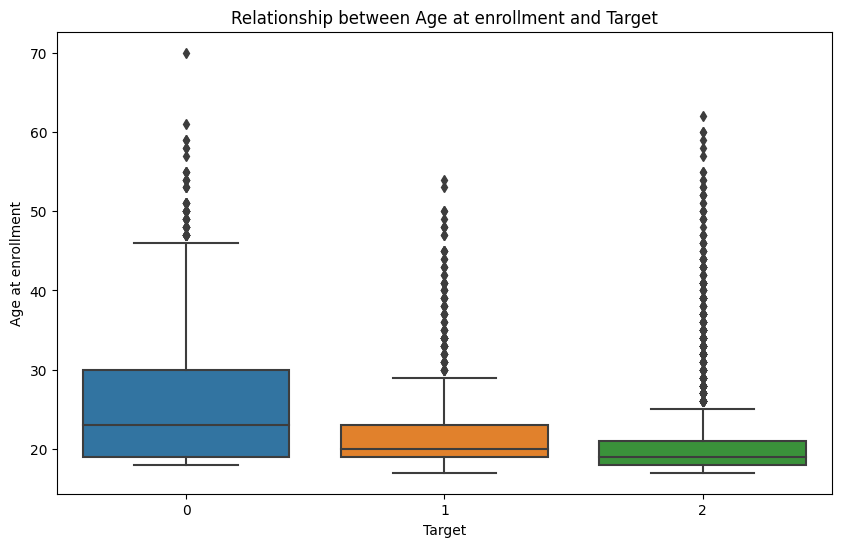

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Age at enrollment', data=new_data)
plt.xlabel('Target')
plt.ylabel('Age at enrollment')
plt.title('Relationship between Age at enrollment and Target')
plt.show()

**Model Training**

In [ ]:
X = new_data.drop('Target', axis=1)
y = new_data['Target']

In [ ]:
# Split the data into training (70%), validation (15%), and testing (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Model Selection**

In [ ]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter = 1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': svm.SVC()
}

In [ ]:
for model_name, model in models.items():
    model.fit(X_train, y_train)

In [ ]:
for model_name, model in models.items():
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')

    accuracy = accuracy * 100

    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}%, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n")

Decision Tree Evaluation:
Accuracy: 66.87%, F1-Score: 0.6698, Precision: 0.6712, Recall: 0.6687

Random Forest Evaluation:
Accuracy: 76.05%, F1-Score: 0.7464, Precision: 0.7454, Recall: 0.7605

Logistic Regression Evaluation:
Accuracy: 74.70%, F1-Score: 0.7266, Precision: 0.7267, Recall: 0.7470

K-Nearest Neighbors Evaluation:
Accuracy: 68.52%, F1-Score: 0.6687, Precision: 0.6643, Recall: 0.6852

AdaBoost Evaluation:
Accuracy: 74.40%, F1-Score: 0.7311, Precision: 0.7306, Recall: 0.7440

XGBoost Evaluation:
Accuracy: 75.60%, F1-Score: 0.7467, Precision: 0.7452, Recall: 0.7560

SVM Evaluation:
Accuracy: 72.44%, F1-Score: 0.7056, Precision: 0.7162, Recall: 0.7244



**Model Hyperparameter Tuning for Random Forest Classifier**

In [22]:
param_grid = {
    'bootstrap': [False,True],
    'max_depth': [5,8,10, 20],
    'max_features': [3, 4, 5, None],
    'min_samples_split': [2, 10, 12],
    'n_estimators': [100, 200, 300]
}

rfc = RandomForestClassifier()

clf = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print(clf.best_params_)
print(clf.best_estimator_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Accuracy:  0.7801204819277109
{'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 300}
RandomForestClassifier(bootstrap=False, max_depth=20, max_features=3,
                       n_estimators=300)


Here the accuracy has been improved

In [23]:
clf = RandomForestClassifier(bootstrap=False, max_depth=10,max_features=3,
                             min_samples_split=12,
                             n_estimators=100, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred)*100, "%")

print("Precision Score: ", precision_score(y_test, y_pred,average='micro'))
print("Recall Score: ", recall_score(y_test, y_pred,average='micro'))
print("F1 Score: ", f1_score(y_test, y_pred,average='micro'))

Accuracy:  76.80722891566265 %
Precision Score:  0.7680722891566265
Recall Score:  0.7680722891566265
F1 Score:  0.7680722891566265


**Model Testing**

In [24]:
for model_name, model in models.items():
  model_y_pred = model.predict(X_test)

  test_accuracy = accuracy_score(y_test, model_y_pred)
  test_f1 = f1_score(y_test, model_y_pred, average='weighted')
  test_precision = precision_score(y_test, model_y_pred, average='weighted')
  test_recall = recall_score(y_test, model_y_pred, average='weighted')

  test_accuracy = test_accuracy * 100

  print(f"{model_name} Evaluation:")
  print(f"Accuracy: {test_accuracy:.2f}%, F1-Score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}\n")

Decision Tree Evaluation:
Accuracy: 68.22%, F1-Score: 0.6823, Precision: 0.6825, Recall: 0.6822

Random Forest Evaluation:
Accuracy: 77.71%, F1-Score: 0.7578, Precision: 0.7581, Recall: 0.7771

Logistic Regression Evaluation:
Accuracy: 76.66%, F1-Score: 0.7493, Precision: 0.7481, Recall: 0.7666

K-Nearest Neighbors Evaluation:
Accuracy: 68.67%, F1-Score: 0.6739, Precision: 0.6676, Recall: 0.6867

AdaBoost Evaluation:
Accuracy: 75.15%, F1-Score: 0.7378, Precision: 0.7319, Recall: 0.7515

XGBoost Evaluation:
Accuracy: 76.36%, F1-Score: 0.7557, Precision: 0.7522, Recall: 0.7636

SVM Evaluation:
Accuracy: 74.85%, F1-Score: 0.7304, Precision: 0.7332, Recall: 0.7485

